# Exercise 3 | TKO_7092 Evaluation of Machine Learning Methods 2024
## deadline: 14.2.2024 - 23:59

Regarding any questions about this exercise, please contact course assistant Jonne Pohjankukka (jjepoh@utu.fi)

********************************************

Student name: Lauri Reima

Student number: 2109673

Student email: loreim@utu.fi


********************************************

## Water permeability prediction in forestry <br>

In this task, the client wants you to estimate the spatial prediction performance of K-nearest neighbor regression model with K=15 (15NN), using spatial leave-one-out cross-validation (i.e. SKCV, with number of folds == number of data points). The client wants you to use the C-index as the performance measure.  

In other words, the client wants you to answer the question: "What happens to the prediction performance of water permeability using 15-nearest neighbor regression model, when the geographical distance between known data and unknown data increases?".

In this task, you have three data files available (with 1691 data points): 

- input.csv, contains the 75 predictor features. 
- output.csv, contains the water permebility values. 
- coordinates.csv, contains the corresponding geographical coordinate locations of the data points. The unit of the coordinates is metre, and you can use Euclidean distance to calculate distances between the coordinate points. 

Implement the following tasks to complete this exercise:

********************************************

#### 1. Z-score standardize the predictor features (input.csv). 

#### 2. Perform spatial leave-one-out cross-validation with 15NN model for the provided data set (refer to the lectures 3.1.3 and 3.1.4 for help). Estimate the water permeability prediction performance (using 15NN model and C-index) with the following distance parameter values: d = 0, 10, 20, ..., 250 (that is, 10 meter intervals from 0m to 250m). 

#### 3. When you have calculated the C-index performance measure for each value of d, visualize the results with the C-index (y-axis) as a function of d (x-axis).

********************************************

Your .ipynb-file must include the following: 

- Your own implementation of the spatial leave-one-out cross-validation for the current task. You can use third-party libraries (e.g. Scikit-learn) if you want for implementing e.g. the 15-nearest neighbor. Also, try to follow good programming practices and add comments to relevant parts of your code explaining what you are doing and why.


- Plot of the graph C-index vs. distance parameter value. 


<br><br><br>
-- START IMPLEMENTING YOUR EXERCISE AFTER THIS LINE --
<br><br><br>

### Import necessary libraries

In [1]:
# In this cell, import all the libraries that you need. For example: 
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split,  LeaveOneOut, KFold, LeaveOneGroupOut
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


### Read in the datasets

In [2]:
# In this cell, read the files input.csv, output.csv and coordinates.csv.
# Print out the dataset dimesions (i.e. number of rows and columns).
input_data = pd.read_csv('input.csv', header=None)
output_data = pd.read_csv('output.csv', header=None)
coordinates_data = pd.read_csv('coordinates.csv', header=None)
print(f"Dimensions: \nInput: {input_data.shape}\nOutput: {output_data.shape}\nCoordinates: {coordinates_data.shape}")

Dimensions: 
Input: (1691, 75)
Output: (1691, 1)
Coordinates: (1691, 2)


### Standardization of the predictor features (input.csv)

In [3]:
# Standardize the predictor features (input.csv) by removing the mean and scaling to unit variance. 
# In other words, z-score the predictor features. You are allowed to use third-party libraries for doing this.
scaler = StandardScaler()
standardized_input = scaler.fit_transform(input_data.values)
standardized_input_df = pd.DataFrame(standardized_input)

### Functions and analysis code

In [4]:
# Include here all the functions and other relevant code that you need in order to implement the task.

# Note! Utilize the following two functions in your implementation:

### Function for calculating C-index ###
# y: array containing true label values.
# yp: array containing the predicted label values.
def cindex(y, yp):
    n = 0
    h_num = 0 
    for i in range(0, len(y)):
        t = y[i]
        p = yp[i]
        for j in range(i+1, len(y)):
            nt = y[j]
            np = yp[j]
            if (t != nt): 
                n = n + 1
                if (p < np and t < nt) or (p > np and t > nt): 
                    h_num += 1
                elif (p == np):
                    h_num += 0.5
    return h_num/n


### Function for calculating the pairwise spatial distances between the data points ###
# The function will return a n-by-n matrix of Euclidean distances. For example, the
# distance_matrix element at indices i,j will contain the spatial distance between 
# data point i and j. Note that the element value is 0 always when i==j.
# coordinate_array: n-by-2 array containing the coordinates of the exercise data points.
def cdists(coordinate_array):
    number_of_observations = coordinate_array.shape[0]
    distance_matrix = np.zeros((number_of_observations, number_of_observations))
    for i in range(0, number_of_observations):
        distance_matrix[i, :] = np.sqrt(np.sum((coordinate_array - coordinate_array[i])**2, axis=1))
    return distance_matrix

### Function for calculating the spatial leave-one-out
# input, output and the distances we want to compare
def spat_loocv(input_data, output_data, distance_params):
    # makes an n x n matrix of distaces
    distance_matrx = cdists(coordinates_data.values)
    knn = KNeighborsRegressor(n_neighbors=15)
    # makes an array of lenth of data from 1....len(data)
    all_ind = np.arange(len(input_data))
    c_indexes = []
    
    for d in distance_params:
        c_index_d = []
        y_pred_values = []
        y_test_values = []
        for i in range(len(input_data)): 
            # calculates and gives the indeces of closest neighbors
            neighbors_indices = np.argsort(distance_matrx[i])  
            
            neighbors_inside_distance = []
            # loops through the indices from closest to furthest and adds closer ones to an array
            for index in neighbors_indices:
                # if distance is bigger than d no need to loop any further
                if distance_matrx[i][index] > d:
                    break
                else:
                    neighbors_inside_distance.append(index)
            # make the train indices of all the indices minus the ones that are closer than d
            train_ind = np.delete(all_ind, neighbors_inside_distance)
            knn.fit(input_data[train_ind], output_data[train_ind])
            prediction = knn.predict(input_data[i].reshape(1, -1))
            y_pred_values.extend(prediction)
            y_test_values.extend(output_data[i])
            
        c_index = cindex(y_test_values, y_pred_values)
        c_index_d.append(c_index)        
        c_indexes.append(np.mean(c_index_d))
    return c_indexes
    

### Results for spatial leave-one-out cross-validation with 15-nearest neighbor regression model

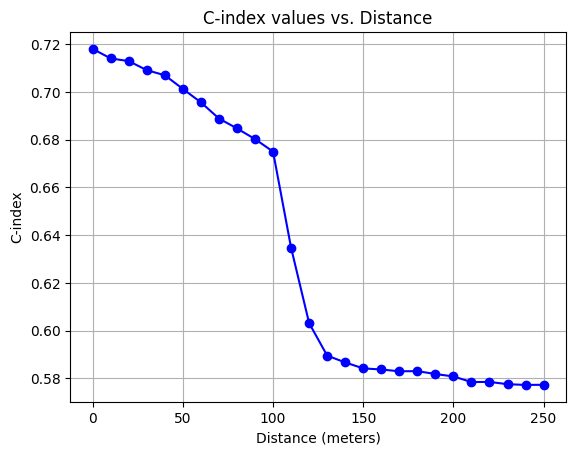

In [5]:
# In this cell, run your script for the Spatial leave-One-Out cross-validation 
# with 15-nearest neighbor regression model and visualize the results as 
# requested in the task assignment.
X = input_data.values  
y = output_data.values  
distance_parameters = range(0, 251, 10)
c_ind_val = spat_loocv(X, y, distance_parameters)

dist = np.arange(0, len(c_ind_val) * 10, 10)
plt.plot(dist, c_ind_val, marker='o', linestyle='-', color='b')
plt.title('C-index values vs. Distance')
plt.xlabel('Distance (meters)')
plt.ylabel('C-index')
plt.grid(True)
plt.show()

### Interpretation of the results

#### In this cell, give a brief commentary on the results, what happens to the prediction performance as the prediction distance increases?
There is a huge drop in performance when the distance grows to over 100 meters but it stabilizes again in 130 meters. But overall it is visible the performance is better with short distances. 